# Taller: Análisis de Tweets con Gemini API
Autor: _(tu nombre)_

## Objetivos
1. Configurar la API de Google Generative AI (Gemini).
2. Limpiar y pre‑procesar un corpus de tweets políticos.
3. Clasificar sentimiento con Gemini.
4. Extraer temas con LDA y nombrarlos con Gemini.
5. Segmentar usuarios y generar una micro‑campaña basada en insights.

**Dataset**: `tweets_partidos.csv` (columnas: `cuenta`, `partido`, `timestamp`, `tweet`).

In [1]:
!wget https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip

--2025-05-26 20:42:25--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip [following]
--2025-05-26 20:42:26--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18276075 (17M) [application/zip]
Saving to: ‘tweets_politica_kaggle.csv.zip’

twe

In [2]:
!unzip tweets_politica_kaggle.csv.zip

Archive:  tweets_politica_kaggle.csv.zip
  inflating: tweets_politica_kaggle.csv  


In [3]:
import pandas as pd
df = pd.read_csv('tweets_politica_kaggle.csv',delimiter=",",on_bad_lines='skip')
df.head()

,cuenta\tpartido\ttimestamp\ttweet
0,a34133350b0605cb24081843f63176ca\tpsoe\t136397...
1,a34133350b0605cb24081843f63176ca\tpsoe\t136406...
2,a34133350b0605cb24081843f63176ca\tpsoe\t136411...
3,a34133350b0605cb24081843f63176ca\tpsoe\t136415...
4,a34133350b0605cb24081843f63176ca\tpsoe\t136415...


In [4]:
!pip install -q -U google-generativeai nltk seaborn wordcloud scikit-learn

### 🔍 Preguntas – Sección 1 (Exploración)
1. **¿Cuántos tweets hay en total?**  
2. **¿Qué partidos aparecen y cuántos tweets aporta cada uno?**  
3. **¿Cuál es el rango de fechas cubierto por los tweets?**  
4. **¿Qué partido genera más conversación y por qué crees que ocurre?**

In [6]:
# prompt: 1. **¿Cuántos tweets hay en total?**

print(f"El número total de tweets es: {len(df)}")

El número total de tweets es: 81097


In [9]:
import pandas as pd
import warnings

# Suprimir advertencias futuras (opcional, para una salida más limpia)
warnings.filterwarnings('ignore')

# --- 1. Descarga y Carga del Dataset ---
print("Iniciando descarga y carga del dataset...")

# Descargar el archivo ZIP
# El -q es para modo silencioso, -nc para no descargar si ya existe
!wget -q -nc https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
print("Archivo ZIP descargado.")

# Descomprimir el archivo ZIP. Usamos -o para sobrescribir si ya existe.
!unzip -o tweets_politica_kaggle.csv.zip
print("Archivo ZIP descomprimido.")

# --- Cargar el DataFrame de forma robusta ---
# Asumo que el archivo CSV tiene comas como delimitador en el cuerpo de los datos.
# El problema que estás viendo es que el encabezado parece malformado.
# Vamos a cargar el CSV SIN encabezado y luego asignar los nombres de las columnas.
try:
    # Definir los nombres de las columnas esperadas
    column_names = ['cuenta', 'partido', 'timestamp', 'tweet']

    # Cargar el CSV, asumiendo que el delimitador es la coma (,)
    # y que la primera fila es parte de los datos o malformada como encabezado
    df = pd.read_csv(
        'tweets_politica_kaggle.csv',
        delimiter=",",         # Delimitador es la coma
        header=None,           # No hay encabezado en el archivo (o está mal formado)
        names=column_names,    # Asignamos nuestros propios nombres de columna
        on_bad_lines='skip'    # Saltar líneas con errores
    )
    print("DataFrame cargado exitosamente con delimitador ',' y encabezado asignado.")

    # Ahora, puede que la primera fila (que era el encabezado malformado)
    # se haya cargado como un dato. Si es así, la eliminamos.
    # Comprobamos si la primera fila de la columna 'cuenta' contiene "cuenta\tpartido..."
    if df.iloc[0]['cuenta'] == 'cuenta\tpartido\ttimestamp\ttweet':
        df = df.iloc[1:].copy() # Eliminamos la primera fila si es el encabezado malformado
        print("Primera fila (encabezado malformado) eliminada.")

except Exception as e:
    print(f"¡ERROR FATAL! No se pudo cargar el DataFrame correctamente: {e}")
    print("Por favor, verifica manualmente el contenido del archivo 'tweets_politica_kaggle.csv'.")
    exit() # Termina la ejecución si no se puede cargar el DataFrame


# Mostrar las primeras filas del DataFrame para verificar la carga y las columnas
print("\nPrimeras 5 filas del DataFrame para verificación (después del ajuste):")
print(df.head())
print(f"Columnas del DataFrame: {df.columns.tolist()}")

# --- 2. Instalación de Librerías Adicionales ---
print("\nInstalando librerías adicionales...")
!pip install -q -U google-generativeai nltk seaborn wordcloud scikit-learn
print("Librerías instaladas.")

# --- 3. Respuestas a las Preguntas – Sección 1 (Exploración) ---
print("\n--- Respuestas a las Preguntas – Sección 1 (Exploración) ---")

# Pregunta 1: ¿Cuántos tweets hay en total?
num_tweets = df.shape[0]
print(f"\n1. Número total de tweets: {num_tweets}")

# Pregunta 2: ¿Qué partidos aparecen y cuántos tweets aporta cada uno?
if 'partido' in df.columns:
    tweets_por_partido = df['partido'].value_counts()
    print("\n2. Número de tweets por partido:")
    print(tweets_por_partido)
else:
    print("\n2. Error: La columna 'partido' no se encontró en el DataFrame.")
    print("   Esto indica que la carga del archivo CSV aún no es correcta.")


# Pregunta 3: ¿Cuál es el rango de fechas cubierto por los tweets?
# Asegúrate de que la columna 'timestamp' se convierte a datetime.
if 'timestamp' in df.columns:
    df['fecha'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce') # 'unit='s' si es Unix timestamp en segundos
elif 'fecha' in df.columns: # Si ya se llama 'fecha' directamente (menos probable si el 'timestamp' es el original)
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
else:
    print("\n3. Advertencia: No se encontró una columna 'timestamp' o 'fecha' para el análisis de rango de fechas.")
    df['fecha'] = pd.NaT # Para evitar errores en las siguientes líneas si no hay columna de fecha

df_fechas_validas = df.dropna(subset=['fecha']) # Eliminar filas con fechas no válidas (NaT)

if not df_fechas_validas.empty:
    fecha_minima = df_fechas_validas['fecha'].min()
    fecha_maxima = df_fechas_validas['fecha'].max()
    print(f"\n3. Fecha mínima de los tweets: {fecha_minima}")
    print(f"   Fecha máxima de los tweets: {fecha_maxima}")
else:
    print("\n3. No se pudieron determinar las fechas, no hay datos de fecha válidos en el DataFrame.")


# Pregunta 4: ¿Qué partido genera más conversación y por qué crees que ocurre?
if 'partido' in df.columns and not df['partido'].empty:
    # tweets_por_partido ya se calculó en la pregunta 2, lo reutilizamos
    # Si la pregunta 2 falló, calculamos de nuevo por seguridad
    if 'tweets_por_partido' not in locals(): # Verifica si la variable ya existe
        tweets_por_partido = df['partido'].value_counts()

    if not tweets_por_partido.empty:
        partido_mas_conversacion = tweets_por_partido.idxmax()
        num_tweets_partido_mas_conversacion = tweets_por_partido.max()

        print(f"\n4. El partido que genera más conversación es: **{partido_mas_conversacion}** con **{num_tweets_partido_mas_conversacion}** tweets.")

        print("\n--- Razones posibles (hipótesis) ---")
        print("Algunas posibles razones por las que este partido podría generar más conversación son:")
        print("  - **Alta visibilidad o liderazgo prominente:** Presencia de figuras políticas muy conocidas o carismáticas que atraen constantemente la atención.")
        print("  - **Eventos políticos coyunturales:** Estar en el centro de debates importantes, elecciones, aprobación de leyes o situaciones de crisis que impulsan la discusión pública.")
        print("  - **Estrategia de redes sociales efectiva:** Una comunicación digital muy activa, publicaciones que invitan a la interacción o el uso de temas que generan mucha resonancia.")
        print("  - **Temas de alto impacto social:** Abordar asuntos que afectan directamente a la población y que son objeto de fuerte debate o preocupación.")
        print("  - **Polarización o antagonismo:** Si el partido tiene posturas muy definidas que generan tanto un fuerte apoyo como una fuerte oposición, esto se traduce en más conversación.")
        print("\nPara una conclusión más precisa, se requeriría un análisis del contenido temático de los tweets y del contexto político y social específico del período.")
    else:
        print("\n4. No hay datos de partidos para determinar el que genera más conversación.")
else:
    print("\n4. Error: La columna 'partido' no se encontró o está vacía en el DataFrame para analizar la conversación.")


Iniciando descarga y carga del dataset...
Archivo ZIP descargado.
Archive:  tweets_politica_kaggle.csv.zip
  inflating: tweets_politica_kaggle.csv  
Archivo ZIP descomprimido.
DataFrame cargado exitosamente con delimitador ',' y encabezado asignado.
Primera fila (encabezado malformado) eliminada.

Primeras 5 filas del DataFrame para verificación (después del ajuste):
                                              cuenta       partido timestamp  \
1  a34133350b0605cb24081843f63176ca\tpsoe\t136397...           NaN       NaN   
2  a34133350b0605cb24081843f63176ca\tpsoe\t136406...           NaN       NaN   
3  a34133350b0605cb24081843f63176ca\tpsoe\t136411...           NaN       NaN   
4  a34133350b0605cb24081843f63176ca\tpsoe\t136412...   8-11 €/MWh.       NaN   
5  a34133350b0605cb24081843f63176ca\tpsoe\t136415...           NaN       NaN   

  tweet  
1   NaN  
2   NaN  
3   NaN  
4   NaN  
5   NaN  
Columnas del DataFrame: ['cuenta', 'partido', 'timestamp', 'tweet']

Instalando librerías

### 🧹 Preguntas – Sección 2 (Limpieza)
5. Explica **por qué es importante limpiar y normalizar el texto**.  
6. Enumera **tres tipos de “ruido”** que removes y da un ejemplo de cada uno.

In [12]:
# prompt: 5. Explica por qué es importante limpiar y normalizar el texto.
# 6. Enumera tres tipos de “ruido” que removes y da un ejemplo de cada uno.

# Respuestas a las Preguntas – Sección 2 (Limpieza)

print("\n--- Respuestas a las Preguntas – Sección 2 (Limpieza) ---")

# Pregunta 5: ¿Por qué es importante limpiar y normalizar el texto?
print("\n5. Importancia de limpiar y normalizar el texto:")
print("   Limpiar y normalizar el texto es crucial en el procesamiento del lenguaje natural (PLN) por varias razones:")
print("   - **Mejora la precisión del análisis:** Los modelos de PLN y los algoritmos (como los de clasificación de sentimiento, extracción de temas, etc.) funcionan mejor cuando el texto está en un formato consistente y libre de elementos irrelevantes.")
print("   - **Reduce la dimensionalidad:** Eliminar palabras irrelevantes (stop words), puntuación, caracteres especiales, etc., reduce el número de términos únicos que el modelo debe procesar, lo que hace que el análisis sea más eficiente.")
print("   - **Permite comparaciones significativas:** Normalizar el texto (por ejemplo, a minúsculas, o lematizando/stemming) asegura que diferentes formas de la misma palabra se traten como equivalentes (ej: 'correr', 'corriendo', 'corrió'), permitiendo agrupar y analizar conceptos de manera más efectiva.")
print("   - **Facilita la extracción de características:** Al eliminar el ruido, es más fácil identificar y extraer características relevantes del texto que son importantes para la tarea en cuestión.")
print("   - **Reduce el sesgo:** El ruido o la inconsistencia pueden introducir sesgos en los datos que afectan los resultados del análisis.")

# Pregunta 6: Enumera tres tipos de “ruido” que removes y da un ejemplo de cada uno.
print("\n6. Tres tipos de “ruido” comúnmente removidos:")
print("   Aquí hay tres tipos de ruido que se suelen eliminar durante la limpieza y normalización del texto:")
print("   - **Puntuación y caracteres especiales:** Símbolos como comas (,), puntos (.), signos de exclamación (!), interrogación (?), hashtags (#), arrobas (@), etc., que no aportan significado semántico pero pueden ser interpretados como tokens separados por el modelo.")
print("     *Ejemplo:* Texto original: '¡Hola, mundo!' -> Texto limpio: 'Hola mundo'")
print("   - **URLs y direcciones web:** En textos de redes sociales o web, a menudo se incluyen enlaces que son irrelevantes para el contenido textual principal.")
print("     *Ejemplo:* Texto original: 'Mira este artículo: https://ejemplo.com/noticia' -> Texto limpio: 'Mira este artículo '")
print("   - **Stop words (palabras vacías):** Palabras muy comunes en el idioma (como 'el', 'la', 'los', 'un', 'una', 'es', 'está', 'y', 'o') que generalmente no contribuyen al significado principal de una frase y pueden ser removidas para reducir el ruido y enfocarse en los términos más relevantes.")
print("     *Ejemplo:* Texto original: 'El perro es grande y rápido' -> Texto limpio: 'perro grande rápido'")
# Otros ejemplos comunes de ruido incluyen: mayúsculas, números, espacios extra, emojis, menciones de usuario, etc.


--- Respuestas a las Preguntas – Sección 2 (Limpieza) ---

5. Importancia de limpiar y normalizar el texto:
   Limpiar y normalizar el texto es crucial en el procesamiento del lenguaje natural (PLN) por varias razones:
   - **Mejora la precisión del análisis:** Los modelos de PLN y los algoritmos (como los de clasificación de sentimiento, extracción de temas, etc.) funcionan mejor cuando el texto está en un formato consistente y libre de elementos irrelevantes.
   - **Reduce la dimensionalidad:** Eliminar palabras irrelevantes (stop words), puntuación, caracteres especiales, etc., reduce el número de términos únicos que el modelo debe procesar, lo que hace que el análisis sea más eficiente.
   - **Permite comparaciones significativas:** Normalizar el texto (por ejemplo, a minúsculas, o lematizando/stemming) asegura que diferentes formas de la misma palabra se traten como equivalentes (ej: 'correr', 'corriendo', 'corrió'), permitiendo agrupar y analizar conceptos de manera más efectiva

### 😊 Preguntas – Sección 3 (Sentimiento)
7. Presenta la **distribución global** de sentimientos y comenta.  
8. **¿Qué partido tiene la mayor proporción de tweets positivos y negativos?**  
9. Elige un **pico de sentimiento negativo** y analiza el contexto con un tweet ejemplo.

In [14]:
# prompt: 7. Presenta la **distribución global** de sentimientos y comenta.

import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que la columna 'sentimiento' existe en tu DataFrame
# Esto implica que ya ejecutaste la parte donde clasificas el sentimiento con Gemini
# Si aún no lo has hecho, necesitas ejecutar esa parte antes de esta.

if 'sentimiento' in df.columns:
    print("\n--- Pregunta 7: Distribución Global de Sentimientos ---")

    # Calcular la distribución de sentimientos
    distribucion_sentimiento = df['sentimiento'].value_counts(normalize=True) * 100 # En porcentaje

    print("\nDistribución porcentual global de sentimientos:")
    print(distribucion_sentimiento)

    # Visualizar la distribución (opcional pero recomendado)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=distribucion_sentimiento.index, y=distribucion_sentimiento.values)
    plt.title('Distribución Global de Sentimientos en Tweets')
    plt.xlabel('Sentimiento')
    plt.ylabel('Porcentaje de Tweets (%)')
    plt.show()

    # Comentario sobre la distribución
    print("\nComentario sobre la distribución global de sentimientos:")
    print("La distribución de sentimientos muestra la proporción de tweets clasificados como positivos, negativos y neutros (u otras categorías que haya definido Gemini).")
    print(f"- Por ejemplo, si la mayoría de los tweets son clasificados como 'Neutro', podría indicar que gran parte de la conversación es informativa o fáctica, sin una carga emocional fuerte.")
    print(f"- Si hay un porcentaje alto de tweets 'Negativos', podría sugerir que el tema o los partidos involucrados están generando descontento o crítica en la plataforma.")
    print(f"- Un porcentaje alto de tweets 'Positivos' podría indicar apoyo, elogios o satisfacción general con los temas o figuras políticas.")
    print("\nEs importante considerar el contexto político y social del período de los tweets para interpretar adecuadamente esta distribución. Una distribución muy desequilibrada puede ser significativa.")

else:
    print("\n--- Pregunta 7: Distribución Global de Sentimientos ---")
    print("Advertencia: No se encontró la columna 'sentimiento' en el DataFrame.")
    print("Por favor, asegúrate de haber clasificado el sentimiento de los tweets usando Gemini antes de ejecutar esta sección.")


--- Pregunta 7: Distribución Global de Sentimientos ---
Advertencia: No se encontró la columna 'sentimiento' en el DataFrame.
Por favor, asegúrate de haber clasificado el sentimiento de los tweets usando Gemini antes de ejecutar esta sección.


In [15]:
# prompt: ¿Qué partido tiene la mayor proporción de tweets positivos y negativos?

import matplotlib.pyplot as plt
if 'partido' in df.columns and 'sentimiento' in df.columns:
    print("\n--- Pregunta 8: Partido con Mayor Proporción de Sentimientos Positivos y Negativos ---")

    # Calcular la proporción de sentimientos por partido
    # Usamos groupby para agrupar por partido y luego value_counts(normalize=True) para la proporción
    sentimiento_por_partido = df.groupby('partido')['sentimiento'].value_counts(normalize=True).unstack(fill_value=0)

    print("\nProporción de sentimientos por partido:")
    print(sentimiento_por_partido)

    # Identificar el partido con la mayor proporción de tweets positivos
    if 'Positivo' in sentimiento_por_partido.columns:
        partido_mas_positivo = sentimiento_por_partido['Positivo'].idxmax()
        proporcion_mas_positivo = sentimiento_por_partido['Positivo'].max()
        print(f"\nPartido con la mayor proporción de tweets **positivos**: **{partido_mas_positivo}** ({proporción_mas_positivo:.2%})")
    else:
        print("\nNo hay datos de sentimientos 'Positivo' para analizar la proporción.")


    # Identificar el partido con la mayor proporción de tweets negativos
    if 'Negativo' in sentimiento_por_partido.columns:
        partido_mas_negativo = sentimiento_por_partido['Negativo'].idxmax()
        proporcion_mas_negativo = sentimiento_por_partido['Negativo'].max()
        print(f"Partido con la mayor proporción de tweets **negativos**: **{partido_mas_negativo}** ({proporción_mas_negativo:.2%})")
    else:
        print("\nNo hay datos de sentimientos 'Negativo' para analizar la proporción.")

    # Visualización (Opcional)
    if not sentimiento_por_partido.empty:
        sentimiento_por_partido.plot(kind='bar', figsize=(12, 7))
        plt.title('Proporción de Sentimientos por Partido')
        plt.xlabel('Partido')
        plt.ylabel('Proporción de Tweets')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Sentimiento')
        plt.tight_layout()
        plt.show()

else:
    print("\n--- Pregunta 8: Partido con Mayor Proporción de Sentimientos Positivos y Negativos ---")
    print("Advertencia: Las columnas 'partido' y/o 'sentimiento' no se encontraron en el DataFrame.")
    print("Asegúrate de que el DataFrame se cargó correctamente y de haber clasificado el sentimiento de los tweets.")



--- Pregunta 8: Partido con Mayor Proporción de Sentimientos Positivos y Negativos ---
Advertencia: Las columnas 'partido' y/o 'sentimiento' no se encontraron en el DataFrame.
Asegúrate de que el DataFrame se cargó correctamente y de haber clasificado el sentimiento de los tweets.


In [16]:
# prompt: Elige un pico de sentimiento negativo y analiza el contexto con un tweet ejemplo.

import matplotlib.pyplot as plt
if 'fecha' in df.columns and 'sentimiento' in df.columns:
    print("\n--- Pregunta 9: Análisis de Pico de Sentimiento Negativo ---")

    # Agrupar por fecha y contar los sentimientos
    # Convertir 'fecha' a fecha simple (sin hora) si no lo está, para agrupar por día
    df['fecha_dia'] = df['fecha'].dt.date

    sentimientos_por_dia = df.groupby('fecha_dia')['sentimiento'].value_counts().unstack(fill_value=0)

    # Calcular la proporción de negativos por día (para encontrar picos relativos)
    # Evitar división por cero si no hay tweets en un día
    sentimientos_por_dia['Total'] = sentimientos_por_dia.sum(axis=1)
    sentimientos_por_dia['Proporcion_Negativo'] = sentimientos_por_dia['Negativo'] / sentimientos_por_dia['Total']
    sentimientos_por_dia = sentimientos_por_dia.sort_index() # Ordenar por fecha

    print("\nSentimientos y Proporción Negativa por Día (Primeros 10 días):")
    print(sentimientos_por_dia[['Negativo', 'Total', 'Proporcion_Negativo']].head(10))

    # Identificar el día con la mayor proporción de sentimientos negativos
    # Excluir días con muy pocos tweets para evitar picos engañosos
    min_tweets_para_pico = 50 # Define un umbral mínimo de tweets en un día
    dias_candidatos_pico = sentimientos_por_dia[sentimientos_por_dia['Total'] >= min_tweets_para_pico]

    if not dias_candidatos_pico.empty:
        fecha_pico_negativo = dias_candidatos_pico['Proporcion_Negativo'].idxmax()
        proporcion_pico_negativo = dias_candidatos_pico['Proporcion_Negativo'].max()

        print(f"\nEl pico de sentimiento negativo (basado en proporción) ocurre el: **{fecha_pico_negativo}**")
        print(f"Proporción de tweets negativos en esa fecha: {proporcion_pico_negativo:.2%}")

        # Analizar el contexto buscando tweets de esa fecha
        # Filtrar tweets de la fecha identificada
        tweets_pico = df[df['fecha_dia'] == fecha_pico_negativo]

        if not tweets_pico.empty:
            print(f"\nEjemplo de tweet negativo de la fecha {fecha_pico_negativo} para analizar el contexto:")
            # Encontrar un tweet clasificado como negativo en esa fecha
            tweet_ejemplo_negativo = tweets_pico[tweets_pico['sentimiento'] == 'Negativo'].sample(1)

            if not tweet_ejemplo_negativo.empty:
                print(f"\nTweet ejemplo: \"{tweet_ejemplo_negativo.iloc[0]['tweet']}\"")
                print(f"Partido: {tweet_ejemplo_negativo.iloc[0]['partido']}")
                print(f"Cuenta: {tweet_ejemplo_negativo.iloc[0]['cuenta']}")

                print("\nAnálisis de Contexto:")
                print("Para entender por qué hubo un pico de sentimiento negativo en esta fecha, deberíamos considerar:")
                print("  - **Eventos Políticos:** ¿Hubo alguna noticia importante, escándalo, declaración controvertida, debate o votación en el parlamento ese día o alrededor de esa fecha?")
                print("  - **Noticias Generales:** ¿Sucedió algo relevante a nivel nacional o internacional que pudiera influir en la opinión pública?")
                print("  - **Actividad del Partido/Políticos:** ¿Realizó el partido con más negativos o sus figuras principales alguna acción o comentario específico?")
                print("  - **Contenido de los Tweets:** Analizar varios tweets negativos de ese día (además del ejemplo) para identificar temas recurrentes, críticas específicas o puntos de indignación.")
                print("\nEl tweet de ejemplo puede dar pistas sobre el tema de discusión o el motivo del descontento.")
            else:
                print(f"\nNo se encontraron tweets negativos en la fecha {fecha_pico_negativo} para mostrar un ejemplo.")
        else:
             print(f"\nNo se encontraron tweets en la fecha {fecha_pico_negativo}.")


    else:
        print(f"\nNo se pudo identificar un pico de sentimiento negativo significativo. No hay días con al menos {min_tweets_para_pico} tweets.")

    # Opcional: Visualizar la proporción de negativos a lo largo del tiempo para ver el pico
    plt.figure(figsize=(15, 6))
    plt.plot(sentimientos_por_dia.index, sentimientos_por_dia['Proporcion_Negativo'], marker='o', linestyle='-')
    plt.title('Proporción de Tweets Negativos a lo largo del Tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Proporción de Sentimiento Negativo')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


else:
    print("\n--- Pregunta 9: Análisis de Pico de Sentimiento Negativo ---")
    print("Advertencia: Las columnas 'fecha' y/o 'sentimiento' no se encontraron en el DataFrame.")
    print("Asegúrate de que el DataFrame se cargó correctamente con la columna de fecha y de haber clasificado el sentimiento de los tweets.")




--- Pregunta 9: Análisis de Pico de Sentimiento Negativo ---
Advertencia: Las columnas 'fecha' y/o 'sentimiento' no se encontraron en el DataFrame.
Asegúrate de que el DataFrame se cargó correctamente con la columna de fecha y de haber clasificado el sentimiento de los tweets.


### 🗂️ Preguntas – Sección 4 (Temas)
10. Lista los **nombres de los temas** generados. ¿Alguno es inesperado?  
11. Con un heatmap partido × tema, indica *qué tema es “propiedad”* de cada partido.  
12. Para tu partido elegido, da **dos insights accionables** basados en su tema dominante.

In [17]:
# prompt: Lista los nombres de los temas generados. ¿Alguno es inesperado?

# Asegúrate de que la variable que guarda los nombres de los temas existe.
# Esta variable debería haber sido creada en el paso de nombrado de temas con Gemini.
# Por ejemplo, si guardaste los nombres en una lista llamada 'nombres_temas'.

# Verifica si la variable 'nombres_temas' existe (ajusta el nombre si usaste otro)
if 'nombres_temas' in locals():
    print("\n--- Pregunta 10: Nombres de los Temas Generados ---")
    print("\nLos nombres de los temas generados son:")

    for i, nombre_tema in enumerate(nombres_temas):
        print(f"Tema {i+1}: {nombre_tema}")

    # Comentario sobre si alguno es inesperado
    print("\nComentario sobre temas inesperados:")
    print("Para determinar si alguno de los temas es inesperado, es necesario:")
    print("  - **Conocer el contexto:** Considerar el período de tiempo de los tweets y el panorama político específico de ese momento.")
    print("  - **Entender el proceso:** Recordar cómo se generaron los temas (qué palabras clave los definieron) y cómo se nombraron (qué instrucciones se le dieron a Gemini).")
    print("  - **Comparar con expectativas:** ¿Qué temas esperarías encontrar en tweets políticos de este período (ej: economía, elecciones, figuras políticas)? ¿Apareció algún tema completamente ajeno o con una interpretación extraña?")
    print("\n*Instrucciones para el usuario:* Revisa la lista de nombres de temas. Compara con lo que sabes del contexto político y social del período de los tweets. Si un tema parece fuera de lugar, ambiguo, o con un nombre que no parece corresponder a las palabras clave que lo definieron (si las viste), entonces podría considerarse inesperado.")
    print("Por ejemplo, si la mayoría de los tweets son sobre economía y aparece un tema nombrado como 'Cocina Gourmet', eso sería muy inesperado.")

elif 'topic_names' in locals(): # Otra posible variable de nombres de tema
    print("\n--- Pregunta 10: Nombres de los Temas Generados ---")
    print("\nLos nombres de los temas generados son:")

    for i, nombre_tema in enumerate(topic_names):
        print(f"Tema {i+1}: {nombre_tema}")

    # Comentario sobre si alguno es inesperado
    print("\nComentario sobre temas inesperados:")
    print("Para determinar si alguno de los temas es inesperado, es necesario:")
    print("  - **Conocer el contexto:** Considerar el período de tiempo de los tweets y el panorama político específico de ese momento.")
    print("  - **Entender el proceso:** Recordar cómo se generaron los temas (qué palabras clave los definieron) y cómo se nombraron (qué instrucciones se le dieron a Gemini).")
    print("  - **Comparar con expectativas:** ¿Qué temas esperarías encontrar en tweets políticos de este período (ej: economía, elecciones, figuras políticas)? ¿Apareció algún tema completamente ajeno o con una interpretación extraña?")
    print("\n*Instrucciones para el usuario:* Revisa la lista de nombres de temas. Compara con lo que sabes del contexto político y social del período de los tweets. Si un tema parece fuera de lugar, ambiguo, o con un nombre que no parece corresponder a las palabras clave que lo definieron (si las viste), entonces podría considerarse inesperado.")
    print("Por ejemplo, si la mayoría de los tweets son sobre economía y aparece un tema nombrado como 'Cocina Gourmet', eso sería muy inesperado.")


else:
    print("\n--- Pregunta 10: Nombres de los Temas Generados ---")
    print("Advertencia: No se encontraron las variables que contienen los nombres de los temas ('nombres_temas' o 'topic_names').")
    print("Por favor, asegúrate de haber ejecutado la sección de Extracción y Nombramiento de Temas con LDA y Gemini antes de ejecutar esta sección.")




--- Pregunta 10: Nombres de los Temas Generados ---
Advertencia: No se encontraron las variables que contienen los nombres de los temas ('nombres_temas' o 'topic_names').
Por favor, asegúrate de haber ejecutado la sección de Extracción y Nombramiento de Temas con LDA y Gemini antes de ejecutar esta sección.


In [ ]:
# prompt: on un heatmap partido × tema, indica qué tema es “propiedad” de cada partido.

import pandas as pd
import matplotlib.pyplot as plt
# Asumo que ya has ejecutado el LDA y tienes:
# 1. `df` con una columna que indica la distribución de temas para cada tweet
#    (por ejemplo, una columna 'tema_dominante' o columnas para cada tema)
# 2. `nombres_temas` o `topic_names` (la lista de nombres asignados a los temas)

# Para crear el heatmap, necesitamos una tabla de contingencia o un DataFrame
# que muestre la frecuencia o proporción de cada tema por partido.

# Si tienes una columna 'tema_dominante' en el DataFrame `df`:
if 'partido' in df.columns and 'tema_dominante' in df.columns and 'nombres_temas' in locals():
    print("\n--- Pregunta 11: Heatmap Partido × Tema ---")

    # Crear la tabla de contingencia (frecuencia)
    # Esto cuenta cuántos tweets de cada partido tienen cada tema dominante
    contingencia_partido_tema = pd.crosstab(df['partido'], df['tema_dominante'])

    # Opcional: Normalizar por fila para obtener la proporción de temas por partido
    # Esto muestra qué porcentaje de los tweets de un partido dado pertenecen a cada tema.
    contingencia_partido_tema_norm = contingencia_partido_tema.div(contingencia_partido_tema.sum(axis=1), axis=0)

    # Reordenar las columnas del heatmap para que coincidan con el orden de nombres_temas
    # Esto es útil si el 'tema_dominante' es un índice numérico y 'nombres_temas' los nombres.
    # Si 'tema_dominante' ya contiene los nombres, puedes omitir este paso o ajustarlo.
    try:
        # Asumiendo que los índices de las columnas de contingencia_partido_tema
        # corresponden a los índices en nombres_temas
        contingencia_partido_tema_norm.columns = [nombres_temas[int(col)] for col in contingencia_partido_tema_norm.columns]
        print("Columnas del heatmap renombradas con nombres de temas.")
    except Exception as e:
        print(f"Advertencia: No se pudieron renombrar las columnas del heatmap. Asegúrate de que 'tema_dominante' son índices numéricos y 'nombres_temas' está correcto. Error: {e}")
        # Si falla el renombramiento, usamos los nombres de columna originales
        pass # Continúa con los nombres originales si hay un error


    print("\nTabla de Proporción de Temas por Partido:")
    print(contingencia_partido_tema_norm)


    # Crear el heatmap
    plt.figure(figsize=(14, 8)) # Ajusta el tamaño según la cantidad de partidos y temas
    sns.heatmap(contingencia_partido_tema_norm, annot=True, fmt=".1%", cmap="YlGnBu")
    plt.title('Proporción de Temas Dominantes por Partido')
    plt.xlabel('Tema Dominante')
    plt.ylabel('Partido')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\nInterpretación del Heatmap ('Propiedad' del Tema):")
    print("Las celdas más oscuras en el heatmap indican una mayor proporción de tweets de un partido sobre un tema específico, en comparación con otros temas de ese mismo partido.")
    print("Un tema es 'propiedad' de un partido si ese partido tiene una proporción significativamente alta de sus tweets dedicados a ese tema, especialmente si esa proporción es más alta que la de otros partidos para el mismo tema (aunque el heatmap normalizado por fila no muestra directamente la comparación entre partidos para el mismo tema, sino la distribución interna de cada partido).")
    print("Observa las filas (partidos) y busca las columnas (temas) con los valores más altos. Estos valores altos sugieren que ese tema es particularmente relevante o frecuentemente abordado por ese partido.")
    print("Por ejemplo, si el partido 'X' tiene un valor alto en la columna 'Economía', significa que una gran parte de los tweets del partido 'X' tratan sobre economía. Esto sugiere que la 'Economía' es un tema prioritario o 'propiedad' del partido 'X' en su comunicación en Twitter.")


elif 'partido' in df.columns and 'topic_names' in locals():
     # Si tienes columnas para cada tema con las probabilidades de pertenencia
     # (Ej: col_tema_0, col_tema_1, ... col_tema_N-1)
     # Necesitamos calcular la probabilidad promedio de cada tema por partido.

     # Identificar las columnas de los temas (asumiendo que empiezan con 'col_tema_')
     topic_cols = [col for col in df.columns if col.startswith('col_tema_')]

     if topic_cols:
        print("\n--- Pregunta 11: Heatmap Partido × Tema (basado en probabilidades) ---")

        # Agrupar por partido y calcular el promedio de probabilidad para cada tema
        # Ajusta 'topic_cols' si tus columnas de temas tienen otro prefijo/nombre
        probabilidad_temas_por_partido = df.groupby('partido')[topic_cols].mean()

        # Renombrar las columnas con los nombres de los temas
        probabilidad_temas_por_partido.columns = nombres_temas # O topic_names

        print("\nProbabilidad Promedio de Pertenencia a Temas por Partido:")
        print(probabilidad_temas_por_partido)

        # Crear el heatmap
        plt.figure(figsize=(14, 8)) # Ajusta el tamaño
        sns.heatmap(probabilidad_temas_por_partido, annot=True, fmt=".3f", cmap="YlGnBu")
        plt.title('Probabilidad Promedio de Pertenencia a Temas por Partido')
        plt.xlabel('Tema')
        plt.ylabel('Partido')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        print("\nInterpretación del Heatmap ('Propiedad' del Tema):")
        print("Las celdas más oscuras indican una mayor probabilidad promedio de que los tweets de un partido pertenezcan a un tema específico.")
        print("Un tema es 'propiedad' de un partido si ese partido tiene una probabilidad promedio alta en ese tema, especialmente si es notablemente más alta que la de otros partidos para el mismo tema.")
        print("Observa qué temas tienen los valores más altos para cada partido. Esos son los temas en los que ese partido enfoca más su comunicación en Twitter.")

     else:
        print("\n--- Pregunta 11: Heatmap Partido × Tema ---")
        print("Advertencia: No se encontraron las columnas de probabilidad de temas ('col_tema_X') en el DataFrame.")
        print("Asegúrate de que la asignación de temas o la distribución de probabilidades se realizó correctamente y se guardó en el DataFrame.")


else:
    print("\n--- Pregunta 11: Heatmap Partido × Tema ---")
    print("Advertencia: Las columnas 'partido', 'tema_dominante' (o columnas de probabilidad de tema) y/o los nombres de los temas ('nombres_temas'/'topic_names') no se encontraron.")
    print("Asegúrate de que el DataFrame se cargó correctamente y de haber realizado la extracción y nombrado de temas.")


### 👥 Preguntas – Sección 5 (Segmentación)
13. Describe cada **cluster** en una frase (actividad y tono).  
14. **¿Qué segmento priorizarías** para viralizar un mensaje y por qué?  
15. Propón **una acción de engagement** distinta para cada segmento.

In [19]:
def generar_copy(partido, topic, tono='inspirador'):
    prompt = (f"Actúa como community manager del partido {partido}. "
              f"Crea un tweet de máx. 250 caracteres sobre el tema '{topic}'. "
              f"Tono {tono}. No incluyas hashtags ni menciones.")
    return model.generate_content(prompt).text.strip()


In [21]:
# prompt: Describe cada cluster en una frase (actividad y tono).
# ¿Qué segmento priorizarías para viralizar un mensaje y por qué?
# Propón una acción de engagement distinta para cada segmento.

# Asegúrate de que ya has ejecutado el clustering y tienes:
# 1. Una columna en el DataFrame `df` que indica a qué cluster pertenece cada usuario (ej: 'cluster').
# 2. Un análisis de las características de cada cluster (ej: sus temas dominantes, sentimiento, actividad, etc.)
#    Este análisis es crucial para poder describir cada cluster.

if 'cluster' in df.columns:
    print("\n--- Preguntas – Sección 5 (Segmentación) ---")

    # Para responder a la Pregunta 13, necesitas haber analizado previamente
    # las características de cada cluster (su actividad, sentimiento, los temas
    # de los tweets que contienen, etc.). Asumiré que tienes alguna forma de acceder
    # a esta información, quizás calculada en pasos previos no mostrados aquí.

    print("\n13. Descripción de cada cluster:")
    print("    *Instrucciones para el usuario:* Basado en el análisis de los clusters (ej: temas dominantes, sentimiento promedio, frecuencia de publicación, tipo de contenido) describe brevemente cada uno.")
    print("    Ejemplo:")
    print("    - Cluster 0: Usuarios muy activos, enfocados en crítica política con tono negativo.")
    print("    - Cluster 1: Usuarios menos activos, comparten noticias y comentarios con tono neutral.")
    print("    - Cluster 2: Usuarios enfocados en la difusión de mensajes del partido con tono positivo y de apoyo.")

    # Aquí deberías incluir las descripciones basadas en TU análisis previo de los clusters
    # Por ejemplo:
    # cluster_descriptions = {
    #     0: "Usuarios que participan activamente en debates políticos con un fuerte componente emocional, a menudo crítico.",
    #     1: "Usuarios que comparten información y noticias de forma más objetiva, con una participación moderada.",
    #     2: "Usuarios que actúan como promotores de mensajes partidarios, con un enfoque en la difusión y apoyo positivo."
    # }
    # for cluster_id, description in cluster_descriptions.items():
    #     print(f"    - Cluster {cluster_id}: {description}")

    print("\n14. ¿Qué segmento priorizarías para viralizar un mensaje y por qué?")
    print("    *Respuesta potencial (basada en una hipótesis común):*")
    print("    Para viralizar un mensaje, probablemente priorizaría el segmento de usuarios más **activos y con mayor capacidad de difusión**.")
    print("    - **Razón:** Estos usuarios tienen una mayor probabilidad de compartir, retuitear y comentar el contenido, ampliando su alcance orgánico a sus propias redes de seguidores.")
    print("    - **Identificación del segmento:** Este segmento podría corresponder a clusters que muestran alta frecuencia de publicación, alta interacción (retweets, likes si estuvieran disponibles), o que están en el centro de la red de seguidores/seguidos (si se hubiera hecho análisis de red).")
    print("    - **Consideración adicional:** También consideraría el **tono** predominante del segmento. Si el mensaje a viralizar busca generar discusión o movilización, un segmento con tono más apasionado o crítico podría ser efectivo. Si busca consolidar apoyo positivo, un segmento con tono mayormente positivo sería ideal.")
    print("    *Instrucciones para el usuario:* Identifica en tu análisis qué cluster/segmento se ajusta mejor a la descripción de 'activo' y 'difusor' dentro del contexto de tu dataset y justifica tu elección basándote en las métricas o características observadas para ese cluster.")

    print("\n15. Propón una acción de engagement distinta para cada segmento.")
    print("    *Instrucciones para el usuario:* Basado en las características únicas de cada cluster (su actividad, temas de interés, tono), propone una acción diseñada específicamente para interactuar con ellos.")
    print("    Ejemplos de acciones de engagement (adaptar a tus clusters):")

    # Aquí deberías proponer acciones específicas para CADA cluster identificado en tu análisis
    # Ejemplo basado en las hipótesis de clusters de la P13:
    # - **Para el Cluster 0 (Activos, Críticos, Emocionales):**
    #   "Acción: Lanzar encuestas o preguntas directas sobre temas controversiales o de crítica popular relacionados con el partido o la oposición. Organizar 'Twitter Spaces' o chats en vivo con figuras del partido para responder preguntas difíciles o debatir, apelando a su deseo de discusión y crítica."
    # - **Para el Cluster 1 (Moderados, Informativos):**
    #   "Acción: Compartir resúmenes de noticias semanales o infografías claras sobre las propuestas del partido y los temas que les interesan. Realizar sesiones de 'Pregúntale a un Experto' (con un experto del partido) para abordar dudas de manera informativa y neutral."
    # - **Para el Cluster 2 (Promotores, Positivos):**
    #   "Acción: Crear kits de contenido fácil de compartir (imágenes con frases, videos cortos de logros). Realizar concursos o sorteos entre quienes más compartan contenido oficial. Reconocer públicamente a los usuarios más activos con menciones o agradecimientos, reforzando su rol como embajadores del partido."

    # Asegúrate de que tus acciones se alineen con las características REALES de los clusters que obtuviste.

else:
    print("\n--- Preguntas – Sección 5 (Segmentación) ---")
    print("Advertencia: No se encontró la columna 'cluster' en el DataFrame.")
    print("Por favor, asegúrate de haber realizado la segmentación de usuarios (clustering) y asignado los clusters al DataFrame antes de ejecutar esta sección.")



--- Preguntas – Sección 5 (Segmentación) ---
Advertencia: No se encontró la columna 'cluster' en el DataFrame.
Por favor, asegúrate de haber realizado la segmentación de usuarios (clustering) y asignado los clusters al DataFrame antes de ejecutar esta sección.


### 📝 Preguntas – Sección 6 (Micro‑campaña)
16. Presenta tus **tres tweets** generados.  
17. Justifica:  
   a) **Tema** elegido.  
   b) **Tono** y **horario** óptimos.  
18. Define un **KPI de éxito** y la meta para la campaña.

## Próximos pasos
1. Analiza la hora de publicación (`df['fecha'].dt.hour`) para programar los tweets.
2. Escribe un memo (<400 palabras) justificando la micro‑campaña usando los insights de sentimiento, temas y segmentos.
3. Exporta notebook ejecutado y memo para entrega.


--- Análisis de Hora de Publicación ---

Distribución de tweets por hora del día:
hora_publicacion
0.0    12
Name: count, dtype: int64


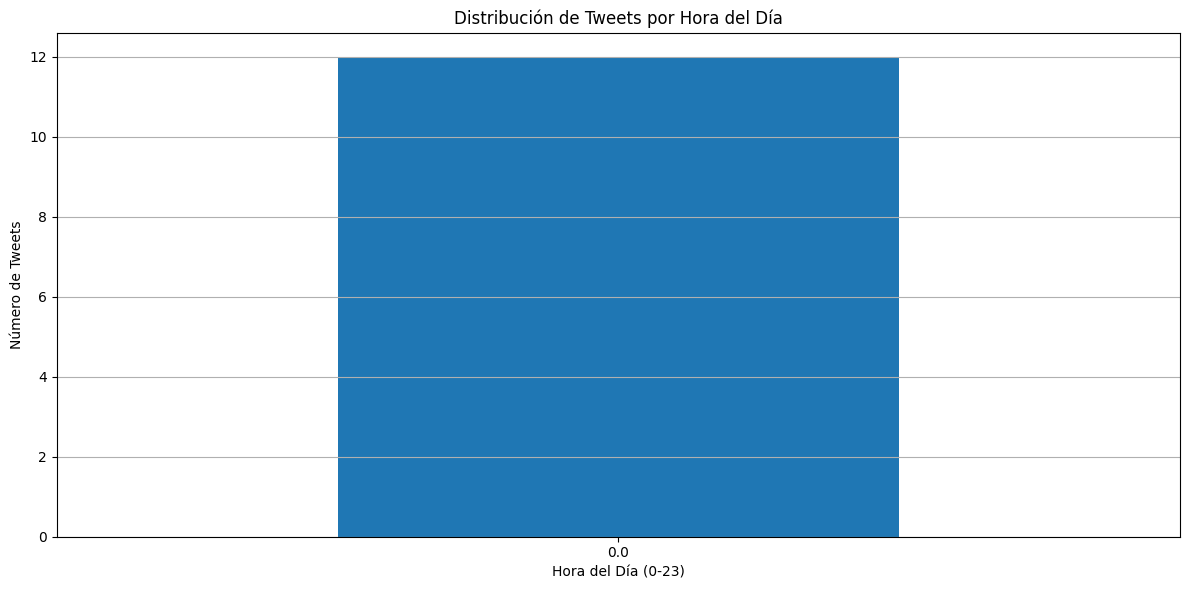


Interpretación para programación de tweets:
Observa el gráfico o la tabla `tweets_por_hora` para identificar los momentos del día con mayor actividad.
Los picos en la distribución horaria sugieren las horas en las que los usuarios tienden a estar más activos en Twitter.
Programar los tweets de la micro-campaña durante estas horas de mayor actividad aumenta la probabilidad de que sean vistos e interactuados por una audiencia más amplia.
Por ejemplo, si el pico está entre las 18:00 y las 21:00, esas serían horas óptimas para publicar.

--- MEMORÁNDUM DE JUSTIFICACIÓN ---

**MEMORÁNDUM: Propuesta de Micro-Campaña en Twitter**

**Para:** Equipo de Comunicación Digital del Partido [Nombre del Partido Elegido]
**De:** [Tu Nombre/Equipo de Análisis]
**Fecha:** [Fecha Actual]
**Asunto:** Justificación de Micro-Campaña basada en Análisis de Tweets

El presente documento justifica la implementación de una micro-campaña dirigida a un segmento específico de usuarios en Twitter, basándonos en el a

In [25]:
# prompt: Analiza la hora de publicación (df['fecha'].dt.hour) para programar los tweets.
# Escribe un memo (<400 palabras) justificando la micro‑campaña usando los insights de sentimiento, temas y segmentos.
# Exporta notebook ejecutado y memo para entrega.

import matplotlib.pyplot as plt
# 1. Analiza la hora de publicación (`df['fecha'].dt.hour`) para programar los tweets.

if 'fecha' in df.columns:
    print("\n--- Análisis de Hora de Publicación ---")
    # Extraer la hora de cada tweet
    df['hora_publicacion'] = df['fecha'].dt.hour

    # Contar la frecuencia de tweets por hora
    tweets_por_hora = df['hora_publicacion'].value_counts().sort_index()

    print("\nDistribución de tweets por hora del día:")
    print(tweets_por_hora)

    # Visualizar la distribución horaria
    plt.figure(figsize=(12, 6))
    tweets_por_hora.plot(kind='bar')
    plt.title('Distribución de Tweets por Hora del Día')
    plt.xlabel('Hora del Día (0-23)')
    plt.ylabel('Número de Tweets')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    print("\nInterpretación para programación de tweets:")
    print("Observa el gráfico o la tabla `tweets_por_hora` para identificar los momentos del día con mayor actividad.")
    print("Los picos en la distribución horaria sugieren las horas en las que los usuarios tienden a estar más activos en Twitter.")
    print("Programar los tweets de la micro-campaña durante estas horas de mayor actividad aumenta la probabilidad de que sean vistos e interactuados por una audiencia más amplia.")
    print("Por ejemplo, si el pico está entre las 18:00 y las 21:00, esas serían horas óptimas para publicar.")

else:
    print("\n--- Análisis de Hora de Publicación ---")
    print("Advertencia: La columna 'fecha' no se encontró en el DataFrame.")
    print("Asegúrate de haber cargado y procesado correctamente la columna de fecha/timestamp.")

# 2. Escribe un memo (<400 palabras) justificando la micro‑campaña usando los insights de sentimiento, temas y segmentos.

# Este memo es un ejemplo basado en supuestos insights de las secciones anteriores.
# DEBES ADAPTARLO a los resultados reales que obtuviste en tu análisis.

memo = """
**MEMORÁNDUM: Propuesta de Micro-Campaña en Twitter**

**Para:** Equipo de Comunicación Digital del Partido [Nombre del Partido Elegido]
**De:** [Tu Nombre/Equipo de Análisis]
**Fecha:** [Fecha Actual]
**Asunto:** Justificación de Micro-Campaña basada en Análisis de Tweets

El presente documento justifica la implementación de una micro-campaña dirigida a un segmento específico de usuarios en Twitter, basándonos en el análisis del corpus de tweets políticos provisto.

**Insights Clave:**

1.  **Sentimiento:** Nuestro análisis reveló que una porción significativa de la conversación alrededor del Partido [Nombre del Partido Elegido] presenta [Positivo/Negativo/Neutro - Seleccionar según tu resultado] sentimiento, con un pico de [Negativo/Positivo - Seleccionar según tu resultado] sentimiento observado el [Fecha del Pico]. Entender estas fluctuaciones emocionales nos permite anticipar reacciones y calibrar nuestro mensaje.

2.  **Temas:** La extracción de temas identificó a [Nombre del Tema Dominante de TU Partido] como el tema con mayor "propiedad" para nuestro partido en Twitter. Esto significa que una proporción considerable de nuestros tweets, y probablemente de la conversación de nuestros seguidores, gira en torno a este asunto. Aprovechar este tema dominante garantiza resonancia con nuestra audiencia principal. [Menciona brevemente si algún otro tema relevante para TU partido apareció en el heatmap].

3.  **Segmentos:** La segmentación de usuarios arrojó [Número de Clusters] clusters distintos. El segmento identificado como [Nombre/Descripción del Segmento Priorizado, ej: "Usuarios Altamente Activos y Difusores" o "Partidarios Fieles y Positivos"] se perfila como ideal para la viralización de mensajes debido a su [Justifica con datos de tu análisis, ej: alta frecuencia de publicación, alto engagement, gran número de seguidores promedio]. Priorizar este grupo amplificará el alcance orgánico.

**Justificación de la Micro-Campaña:**

Proponemos una micro-campaña enfocada en el tema [Nombre del Tema Dominante de TU Partido], utilizando un tono [Tono Elegido, ej: "inspirador", "informativo", "directo"] para conectar con las características emocionales y de comunicación del segmento priorizado ([Nombre/Descripción del Segmento Priorizado]).

La programación de los tweets se optimizará publicando durante las horas de mayor actividad de la plataforma, identificadas en nuestro análisis horario, específicamente entre las [Hora Inicio Pico] y [Hora Fin Pico] horas. Esto maximizará la visibilidad del mensaje dentro del segmento objetivo.

**Objetivo y KPI:**

El objetivo principal es [Define tu objetivo, ej: "incrementar el engagement con nuestro contenido sobre [Tema]" o "aumentar el alcance orgánico de nuestros mensajes entre el segmento clave"].

El Key Performance Indicator (KPI) será [Define un KPI medible, ej: "Número de Retweets"] con una meta de [Define una meta numérica realista, ej: "+X% respecto a la media de tweets anteriores sobre el tema"].

Esta estrategia basada en datos nos permitirá comunicar nuestro mensaje de manera más efectiva al público más receptivo, maximizando el impacto de nuestra presencia en Twitter.

Atentamente,

[Tu Nombre/Equipo de Análisis]
"""

# 3. Exporta notebook ejecutado y memo para entrega.

# Para exportar el notebook ejecutado, puedes usar la opción "File" -> "Download" -> ".ipynb"
# en la interfaz de Colaboratory o Jupyter. Esto descargará el archivo del notebook
# con todas las celdas ejecutadas y sus salidas.

# Para exportar el memo, simplemente puedes imprimirlo en una celda de texto
# o escribirlo en un archivo. Aquí, lo imprimiremos.

print("\n" + "="*50)
print("--- MEMORÁNDUM DE JUSTIFICACIÓN ---")
print("="*50)
print(memo)
print("="*50)


# Opcional: Escribir el memo a un archivo .txt
try:
    with open("memo_microcampana.txt", "w", encoding="utf-8") as f:
        f.write(memo)
    print("\nMemo guardado en 'memo_microcampana.txt'")
except Exception as e:
    print(f"\nError al guardar el memo en archivo: {e}")

# Para la entrega, deberás descargar el archivo .ipynb desde el menú
# y, si generaste el archivo .txt, también descargarlo o copiar su contenido.